ML@ Cezeaux - by Emille Ishida

### Machine Learning Tutorial

# Section 1.b - Supervised learning: classification
by [Emille Ishida](https://www.emilleishida.com/)

### *Take home message 2: It is crucial to understand the algorithm you are using*

**Goal:** 1. Get acquainted with a basic machine learning algorithm    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. Discuss hyper parameters  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3. Write your classifier  

**Task**: Star-Galaxy Classification  

**Data**: Clean data resulting from [Notebook 1](EDA_SDSS_answers.ipynb)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;~9100 objects (lines - depends on how you extracted the outliers)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;11 features (columns)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Features we are interested in:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$ug$: u-g SDSS color  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$gr$: g-r SDSS color   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$class$: source classification

In [1]:
# import some basic libaries 
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Step 1: Pre-processing

We start by loading the data and checking if our variables of interest are given.
 
<div class="alert alert-info"> 
PS1: as we already cleaned this data, we will not perform an extensive EDA here, but remember that you should always make similar tests to those shown in <a href='EDA_SDSS.ipynb'>Notebook 1</a> every single time... and again, just to be sure.
</div>

In [2]:
# load data
data = pd.read_csv('../data/SDSS_star_galaxy_clean.csv')

# check columns
data.keys()

Index(['objid', 'u', 'g', 'r', 'i', 'z', 'class', 'ug', 'gr', 'ri', 'iz'], dtype='object')

In [3]:
data.shape

(9150, 11)

We see that the data we want is there, but there is a lot of other stuff as well.  
Select only the columns that are interesting to you. 

In [4]:
# make a new data frame with the columns you need
def select_columns(data_frame, column_names):
  new_frame = data_frame.loc[:, column_names]
  return new_frame

selected_columns = ['ug', 'gr', 'class']
data_use = select_columns(data, selected_columns)

# confirm remaining columns
data_use.keys()

data_use_class = data_use.replace(['STAR', 'GALAXY'], [1, 2])

data_use_class.head(10)

,ug,gr,class
0,2.43166,1.09541,1
1,1.44831,0.53812,1
2,1.19129,0.71741,2
3,1.16264,0.44156,1
4,1.28683,-0.17527,1
5,0.96354,0.30328,1
6,1.49327,0.78458,2
7,1.13497,0.46474,1
8,0.93444,0.29631,1
9,0.95874,0.22013,2


In [5]:
# convert categorical features like STAR, GALAXY to integer codes
# STAR = 0, GALAXY = 1

# for testing only

from sklearn.preprocessing import OneHotEncoder

#enc = OneHotEncoder(sparse=False)
#data_use_enc = enc.fit_transform(data_use)
#print(type(data_use))
#print(type(data_use_enc.toarray()))
#print(data_use_enc[:10])

from sklearn.preprocessing import LabelEncoder

#enc = LabelEncoder()
#data_use_class = data_use["class"]
#data_use_class_enc = enc.fit_transform(data_use_class)
#print(enc.classes_)
#data_use_class_enc

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2703087470>,
      dtype=object)

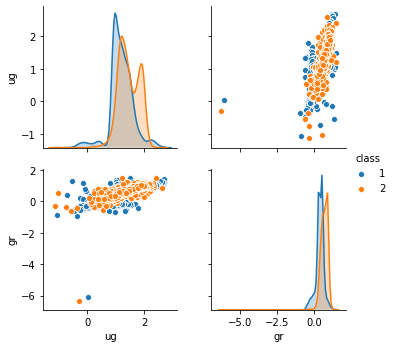

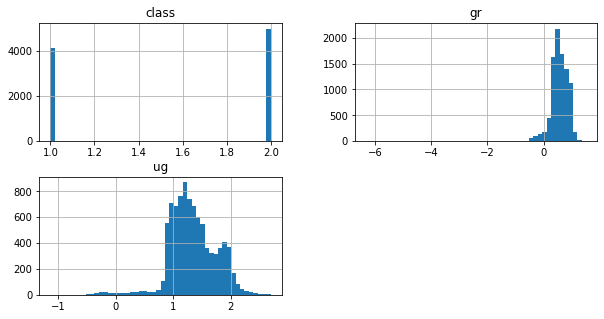

In [6]:
# take a look at the data you just separated
sns.pairplot(data_use_class, hue='class', vars=['ug', 'gr'])
data_use_class.hist(bins=50, figsize=(10,5))

### Step 2: Separate your data samples

All supervised learning tasks are made of (at least) 4 phases:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1) **train**: training samples (requires features and labels)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2) **optimize**: validation sample (requires features and labels)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Repeat 1-2 until you are happy with the results**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3) **evaluate results**: test sample (requires features and labels)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4) **predict**: target sample (there are only you features, you should believe your code at this point)  
      
        
        
This means that your labelled sample needs to be divided in at least 3 samples: training, validation and test.  
So, in order to continue we must construct these samples.


In [7]:
from sklearn.model_selection import train_test_split

# separate 60% for training and 20% for validation and 20% test
# WARNING: there is probably a smarter way to do this
X_train, X, y_train, y = train_test_split(data_use_class[['ug', 'gr']], data_use_class['class'], test_size=0.4, random_state=1)
X_test, X_validation, y_test, y_validation = train_test_split(X, y, test_size=0.5, random_state=1)

# check your samples (size, features, etc.)
print('training sample:    ', X_train.shape, y_train.shape) 
print('validation sample:  ', X_validation.shape, y_validation.shape)
print('test sample:        ', X_test.shape, y_test.shape)

print(type(X_train))
print(type(y_train))
#X_train.head()
#X_train.size
#X.head()
#X.size
#y.head()
X_train.keys()

training sample:     (5490, 2) (5490,)
validation sample:   (1830, 2) (1830,)
test sample:         (1830, 2) (1830,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


Index(['ug', 'gr'], dtype='object')

### Step 3: Build a Nearest Neighbor classifier

As a start, we will construct a k-nearest neighbor algorithm (kNN) with k = 1.  
This means that the class of a test point will be given by the class of its nearest neighbor.  
We can describe this strategy as:  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; For all objects in the unlabelled sample:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1) Calculate the distance to all points in the training sample  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2) Identify its closest neighbor  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3) Assign the class of its nearest neighbor  

In [8]:
# Build a 1-nearest neighbor classifier

from sklearn import neighbors
from matplotlib.colors import ListedColormap

n_neighbors = 1
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def my_NearestNeighbor(train_features, train_labels, unlabelled_features):
    """
    Classify an unlabelled using a k=1 nearest neighbor algorithm.
    
    input: train_features - array, dim=(number of objects, number of features)
           train_labels - array, dim=(number of objects, 1)
           unlabelled_features - array, dim=(number of objects, number of features)
           
    output: estimated classes for all lines in test_features
            array, dim(number of objects, 1)       
    """
    
    clf.fit(train_features, train_labels)
    
    z = clf.predict(unlabelled_features)
    
    # plot the decision boundary
    
    # step size in the mesh
    h = 0.02
    
    # tf and tl are ndarray
    tf = train_features.get_values()
    tl = train_labels.get_values()
    
    print("tf type = ", type(tf))
    print("tf shape = ", tf.shape)
    
    print("tl type = ", type(tl))
    print("tl shape = ", tl.shape)
    
    x_min, x_max = tf[:, 0].min() - 1, tf[:, 0].max() + 1
    y_min, y_max = tf[:, 1].min() - 1, tf[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    zz = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # put the result into a color plot
    zz = zz.reshape(xx.shape)
    
    print("xx shape = ", xx.shape)
    print("yy shape = ", yy.shape)
    print("zz type = ", type(zz))
    print("zz shape = ", zz.shape)
    
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap=cmap_light)
    
    # plot also the training points
    
    plt.scatter(tf[:, 0], tf[:,1], c=tl, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    # plot the validation points
    
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap=cmap_light)
    
    print("z type = ", type(z))
    
    uf = unlabelled_features.get_values()
    
    plt.scatter(uf[:, 0], uf[:, 1], c=z, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.show()
    
    # calculate distances
   
    # assign for each element in the test sample the class of its nearest neighbor

    return z


Estimate the classes of all objects in the test sample

tf type =  <class 'numpy.ndarray'>
tf shape =  (5490, 2)
tl type =  <class 'numpy.ndarray'>
tl shape =  (5490,)
xx shape =  (492, 289)
yy shape =  (492, 289)
zz type =  <class 'numpy.ndarray'>
zz shape =  (492, 289)
z type =  <class 'numpy.ndarray'>


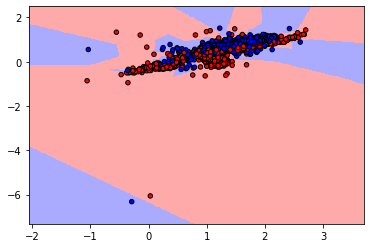

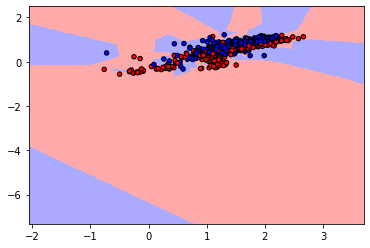

array([2, 2, 2, 2, 1, 1, 1, 2, 1, 2])

In [9]:
class_estimate = my_NearestNeighbor(X_train, y_train, X_validation)

# quick look in the first 10 estimated classes
class_estimate[:10]

#y_validation.head(10)

### Step 4:  Evaluate your results

Now that you have a classifier and already applied it, let's quantify the results.  
Create a metric function that calculates the fraction of correct classifications. 

In [28]:
from sklearn.metrics.pairwise import euclidean_distances as dist
    
distances = dist(X_test, X_train)

test_labels = np.array(y_train.values[np.argmin(distances, axis = 1)])

test_labels[:10]

array([2, 1, 2, 2, 2, 2, 2, 2, 1, 1])

In [35]:
def metric(estimated_classes, true_classes):
    """
    Calculate the fraction of correct classification results. 
    
    input: estimated_classes, array - dim=(number of objects,)
           true_classes, array - dim=(number of objects, )
           
    output: fraction of correct classifications
    """
    
    # get the number of objects in the sample
    print(estimated_classes.shape)
    print(true_classes.shape)
    
    n_objs = true_classes.shape[0]
    
    # get the number of correct classifications
    correct_number = sum(estimated_classes == true_classes)
    
    return float(correct_number/n_objs)

In [38]:
# Calculate metrics
accuracy = metric(class_estimate, y_validation)

print('accuracy: ', accuracy)

R2_knn_val = clf.score(X_validation, y_validation)
print("R2_knn_val = ", R2_knn_val)

(1830,)
(1830,)
accuracy:  0.7846994535519126
R2_knn_val =  0.7846994535519126


### Step 5: Optimize the classifier

The procedure used above aimed to illustrate how you can construct your own classifier, but it is not very practical. Whenever possible, we should make use of available libraries.  

Let's reproduce what we did below using [scikit-learn](https://scikit-learn.org/stable/).

In [44]:
from sklearn import neighbors 
from sklearn.metrics import accuracy_score

# determine number of neighbors
#nn = 10
#weights = 'distance'              # this can be 'uniform' or 'distance'

nn = 1
weights = 'uniform'              

# create an instance of the classifier
classifier = neighbors.KNeighborsClassifier(nn, weights=weights)

# train (or fit) the classifier
classifier.fit(X_train, y_train)

# predict the classes of the test sample
class_estimate_sklearn = classifier.predict(X_validation)

# calculate metrics
#accuracy_sklearn = accuracy_score(class_estimate, y_validation, normalize=True)
accuracy_sklearn = accuracy_score(y_validation, class_estimate_sklearn, normalize=True)

print('accuracy give by sklearn: ', accuracy_sklearn)

accuracy give by sklearn:  0.7846994535519126


Using scikit-learn allows us to easily manipulate the parameters of our algorithm.  
Before we can move forward, we need to optimize these results to the best of our abilities.  
Ask yourself: **Can the results above be improved ?**  

*Try changing the number of neighbors and weights and see how the results change*

*Only go to the next step once you are satisfied with the results!!!*

### Step 6: Calculate final results

In order to ensure some generality to the results of the trained classifier, you must always report its performance in an independent data set, which was not used for training. The aim of the `test` sample is to mimic the results which you would find in the target sample.

In [45]:
# predict the classes of the test sample
class_estimate_test = classifier.predict(X_test)

# calculate metrics
accuracy_test = accuracy_score(class_estimate_test, y_test, normalize=True)

print('accuracy calculated on test sample : ', accuracy_test)

accuracy calculated on test sample :  0.7956284153005464


And this is the accuracy of your optimized classifier.. and the numbers you should report when quoting any output from it!

However, this number is not the reason your classifier was built!  
Now that you have a working classifier your desired output is a list of classes for each object in a completely new sample for which no labels exist.  

So let's read still another data set for which no labels are known.

In [14]:
# load data
data_target = pd.read_csv('../data/SDSS_star_galaxy_target.csv')

# check features
data_target.keys()

FileNotFoundError: [Errno 2] File b'../data/SDSS_star_galaxy_target.csv' does not exist: b'../data/SDSS_star_galaxy_target.csv'

**Notice that for saving time, this data set has already been cleaned. In a realistic situation, all the pre-processing performed in the labelled data which does not involve the labels themselves should also be applied to the target sample!**

Now, let's use our classifier:

In [ ]:
# Use the classifier you optimized above to estimate the classes for the target sample
class_estimate_target = 

# quick look into the first classes


#### You can now say that you have a new catalog of stars and galaxies, given by:

In [ ]:
class_estimate_target

#### whose classes can be trusted to the level of:

In [ ]:
print(round(100*accuracy_test), '%')

### You can know use this catalog to do your science!

<div class="alert alert-info">
PS2: In this notebook used only 2 features due to time constraints, but feel free to try it with all collumns. Try accessing, for example, how your results change when you add more information. 
</div>

------------------------------------------------------------------------------------------------------------------
Summary:

## Machine Learning Model    

**Task**:  Identify stars and galaxies based on their photometric measurements.  

       input: 2 different colours in SDSS broad-band filters: u-g and g-r
       output: estimated classes
       
**Task Category**:   Classification

**Data**: Extract from SDSS-DR14 as available through [Kaggle](https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey#Skyserver_SQL2_27_2018%206_51_39%20PM.csv)  
        
        2 Features, x 
              u-g       u - g colour in SDSS system
              g-r       g - r colour in SDSS system
    
        1 response variable (label), y    
            class
            
**Machine Learning category**:  

        Supervised Learning

**Set of possible samples**:  

        ~9100 objects
        
**Set of possible labels**:

        2 classes: STAR or GALAXY
        
**Learner**:
    
        1 - Nearest neighbor    
        
**Loss function**:

        1 - Distance-based